In [1]:
import warnings ; warnings.filterwarnings('ignore')

In [2]:
import colour, h5py, time, pickle, pandas, random, os
from scipy.stats.mstats import zscore
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.formula.api as sm
from IPython.display import Markdown as md
from scipy import stats

In [3]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [234]:
def show_params(model_, index_ =-1): 
    
    def sigfigs(x): 
        # decimal places
        d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
        # the numeric value in front of it
        n = np.ceil(float(str('%.02e'%x)[0:3]))
        return n, d
    
    beta = model_.params[index_]
    pval = model_.pvalues[index_]
    rsqrd= model_.rsquared
    df_model = model_.df_model
    df_resid = model_.df_resid
    tvalues = model_.tvalues[index_]
    
    if pval < .05: 
        _nums = sigfigs(pval)
        if _nums[1] > 2: 
            stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p < %.0f $ x $ 10 ^{-%d} $"
            report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, _nums[0], _nums[1])
        else: 
            stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p < .05 $"
            report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues)
    else: 
        
        stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p > .05$"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues) 
    
    return md(report), report

In [235]:
_location = '/Users/biota/work/mtl_perception/summary/figures/' 

In [236]:
import electrophysiological.analyses as neural

In [237]:
n_iterations = 100

In [238]:
vvs_path = os.path.abspath(
    'electrophysiological/ventral_neural_data.hdf5')

In [239]:
reliability = neural.split_half_correlation(vvs_path, 
                                            n_iterations, 
                                            np.mean)

In [240]:
pls_vvs_dir = os.path.abspath('electrophysiological/pls_fitting_results')

In [241]:
pls_fits = neural.layer_fits(pls_vvs_dir, np.median, reliability)

### median split-half reliability for IT

In [242]:
md(r'$r=%.02f \pm %.02fSTD$'%(np.median(reliability['IT_NEURONS']), 
                              np.std(reliability['IT_NEURONS'])))

$r=0.73 \pm 0.24STD$

### median split-half reliability for V4

In [243]:
md(r'$r=%.02f \pm %.02fSTD$'%(np.median(reliability['V4_NEURONS']), 
                              np.std(reliability['V4_NEURONS'])))

$r=0.62 \pm 0.22STD$

### first half fits V4 better

In [244]:
_v4half1 = pls_fits['v4']['mu'][:len(pls_fits['it']['mu'])//2]
_v4half2 = pls_fits['v4']['mu'][len(pls_fits['it']['mu'])//2:]

_v4t, _v4p = stats.ttest_ind(_v4half1, _v4half2) 

md(r'$ t(%d)=%.02f, p < %.03f$'%(len(_v4half1)-1, _v4t,  _v4p))

$ t(8)=2.70, p < 0.015$

### second half fits IT better

In [245]:
_ithalf1 = pls_fits['it']['mu'][len(pls_fits['it']['mu'])//2:]
_ithalf2 = pls_fits['it']['mu'][:len(pls_fits['it']['mu'])//2]
_itsplit = stats.ttest_ind(_ithalf1, _ithalf2) 
md(r'$ t(%d)=%.02f, p < %.03f$'%(len(pls_fits['it']['mu'])//2-1, 
                                 _itsplit[0], 
                                 _itsplit[1]))

$ t(8)=3.70, p < 0.002$

In [246]:
_increasing_itfit = smf.ols('zscore(y)~zscore(x)', 
                            data=pandas.DataFrame(
                                {'y':pls_fits['delta'], 
                                 'x':np.arange(len(pls_fits['delta']))}
                            ))
show_model_parameters(_increasing_itfit.fit())[0]

$R^{2}_{model} = 0.96$, $\beta = 0.98$, $F(1, 17)$ = $20.91, p < 2 $ x $ 10 ^{-13} $

# metaparameters for analysis

### identify 'IT-like' and 'V4-like' layers 

In [247]:
it_layer = pls_fits['layers'][ pls_fits['it']['mu'].argmax() ] 
v4_layer =  pls_fits['layers'][ pls_fits['v4']['mu'].argmax() ] 

In [248]:
md('%s  'r'$r=%.02f \pm %.02fSTD$'%(it_layer,
                                    pls_fits['it']['mu'].max(),
                                    pls_fits['it']['std'][
                                        pls_fits['it']['mu'].argmax()]))

conv5_1  $r=0.88 \pm 0.16STD$

# Diagnostic Experiments

In [65]:
import retrospective.combine_results as retrospective

In [66]:
base_directory = '/Users/biota/work/mtl_perception/retrospective/'

In [67]:




meta_df, meta_statistics, nondiagnostic = retrospective.across_studies(
    it_layer,
    v4_layer, 
    base_directory)




## Meta-analysis (sans model estimates)

### A significant difference between PRC-lesioned and PRC-intact subjects

In [68]:
prc_lesioncontrol_test = smf.ols(formula='prc_delta~1', data=meta_df)

In [69]:
show_model_parameters(prc_lesioncontrol_test.fit())[0]

$R^{2}_{model} = 0.00$, $\beta = 0.14$, $F(0, 13)$ = $2.68, p < .05 $

### Not a significant difference between HPC-lesioned and HPC-intact subjects

In [70]:
hpc_lesionintact_test = smf.ols(formula='hpc_delta~1', data=meta_df)

In [233]:
show_params(hpc_lesionintact_test.fit())[0]

NameError: name 'show_params' is not defined

### A significant difference between lesioned and intact subjects by group (PRC vs. HPC)

In [72]:
prc_hpc_lesionintact_difference = {
    'delta': np.concatenate([meta_df['hpc_delta'], 
                             meta_df['prc_delta']]),
    'group': np.concatenate([np.repeat('hpc', len(meta_df)), 
                             np.repeat('prc', len(meta_df))])}

prc_hpc_lesionintact_test = smf.ols(formula='delta~group', 
                                    data=prc_hpc_lesionintact_difference).fit()

show_params(prc_hpc_lesionintact_test)[0]

$R^{2}_{model} = 0.17$, $\beta = 0.13$, $F(1, 26)$ = $2.34, p < .05 $

## An "IT-like" model layer predicts the behavior of PRC-lesioned subjects

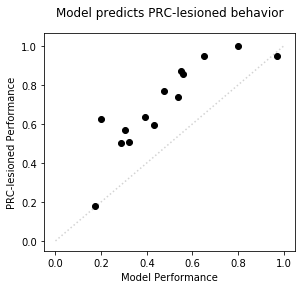

In [73]:
n_ = len(meta_df)
prc_it_prediction = smf.ols("prc_lesion ~ %s"%it_layer, meta_df).fit()
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['prc_lesion'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model predicts PRC-lesioned behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('PRC-lesioned Performance'); 

In [74]:
show_model_parameters(prc_it_prediction)[0]

$R^{2}_{model} = 0.74$, $\beta = 0.86$, $F(1, 12)$ = $5.92, p < 7 $ x $ 10 ^{-5} $

### "IT-like" model does not predict HPC-lesioned performance

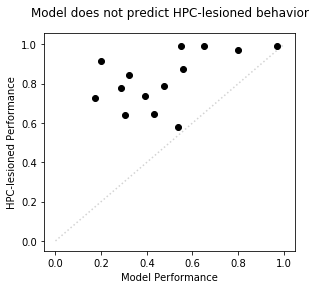

In [75]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['hpc_lesion'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model does not predict HPC-lesioned behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance'); 

In [76]:
hpc_it_prediction = smf.ols("hpc_lesion ~ %s"%it_layer, meta_df).fit()
show_model_parameters(hpc_it_prediction)[0]

$R^{2}_{model} = 0.27$, $\beta = 0.33$, $F(1, 12)$ = $2.11, p > .05$

In [77]:
hpc_it_prediction = smf.ols("hpc_intact ~ %s"%it_layer, meta_df).fit()
show_model_parameters(hpc_it_prediction)[0]

$R^{2}_{model} = 0.26$, $\beta = 0.28$, $F(1, 12)$ = $2.04, p > .05$

## An "IT-like" model layer does not predict the behavior of PRC-intact subjects

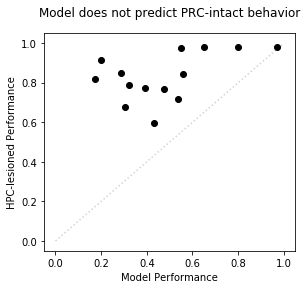

In [78]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['prc_intact'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model does not predict PRC-intact behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance');

In [79]:
prcintact_it_prediction = smf.ols("prc_intact ~ %s"%it_layer, 
                                  meta_df[['prc_intact', it_layer]])

show_model_parameters(prcintact_it_prediction.fit())[0]

$R^{2}_{model} = 0.24$, $\beta = 0.27$, $F(1, 12)$ = $1.97, p > .05$

### PRC-intact control subjects ourperform the model

In [80]:
_tmpdf = pandas.DataFrame({'delta': meta_df['prc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.36$, $F(0, 13)$ = $6.82, p < 2 $ x $ 10 ^{-5} $

In [81]:
_tmpdf = pandas.DataFrame({'delta': meta_df['prc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.36$, $F(0, 13)$ = $6.82, p < 2 $ x $ 10 ^{-5} $

### Selective HPC-lesions subjects ourperform the model

In [82]:
_tmpdf = pandas.DataFrame({'delta': meta_df['hpc_lesion']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

$R^{2}_{model} = -0.00$, $\beta = 0.35$, $F(0, 13)$ = $6.64, p < 2 $ x $ 10 ^{-5} $

In [83]:
_tmpdf = pandas.DataFrame({'delta': meta_df['hpc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.36$, $F(0, 13)$ = $6.85, p < 2 $ x $ 10 ^{-5} $

### Interaction between PRC-intact and -lesioned subjects

In [84]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[it_layer], meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
prcinteraction = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(prcinteraction)[0]

$R^{2}_{model} = 0.68$, $\beta = 0.59$, $F(3, 24)$ = $2.97, p < 7 $ x $ 10 ^{-3} $

In [85]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[it_layer], meta_df[it_layer])), 
     'human': np.concatenate((meta_df['hpc_lesion'], meta_df['hpc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
hpcinteraction = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(hpcinteraction)[0]

$R^{2}_{model} = 0.27$, $\beta = 0.05$, $F(3, 24)$ = $0.23, p > .05$

### PRC-dependence scales with model performance

In [86]:
linear_dependence = smf.ols('prc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

$R^{2}_{model} = 0.49$, $\beta = -0.59$, $F(1, 12)$ = $-3.40, p < 6 $ x $ 10 ^{-3} $

In [87]:
linear_dependence = smf.ols('prc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

$R^{2}_{model} = 0.49$, $\beta = -0.59$, $F(1, 12)$ = $-3.40, p < 6 $ x $ 10 ^{-3} $

### Model performance does not predict HPC-related behavior

In [88]:
linear_dependence = smf.ols('hpc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

$R^{2}_{model} = 0.03$, $\beta = -0.05$, $F(1, 12)$ = $-0.62, p > .05$

In [89]:
linear_dependence = smf.ols('hpc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

$R^{2}_{model} = 0.03$, $\beta = -0.05$, $F(1, 12)$ = $-0.62, p > .05$

In [90]:
for group in ['prc', 'hpc']: 
    color_range = {'prc':['#4B0082', '#FF1493'], 'hpc':['#5d13e7', '#1ee3cf']}[group]
    colors = [i.rgb for i in colour.Color(color_range[0]).range_to(colour.Color(color_range[1]), len(meta_statistics))]
    meta_statistics['%s_colors'%group] = colors
    
    
    

# Visualize Main Finding

In [91]:
def meta_analytic_results(i_layer, i, l, c): 
    
    # helper function
    def plot_nice_line(model_, params={}, title=''): 
        m, b = model_.coef_[0], model_.intercept_[0]
        xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
        return plt.plot(xs, xs * m + b, **params, 
                        solid_capstyle = ['butt','round','projecting'][1])
    
    # helper function
    def plot_diagonal(label=''): 
        return plt.plot([0, 1], [0, 1], color='grey', 
                        linestyle='--', zorder=-1, label=label)

    # data 
    mod_ = meta_df[i_layer].values
    prc_ = meta_df['prc_lesion'].values
    hpc_ = meta_df['hpc_lesion'].values
    con_prc = meta_df['prc_intact'].values
    con_hpc = meta_df['hpc_intact'].values
    
    fig = plt.figure(constrained_layout=True, figsize=[7.5, 4])
    gs = fig.add_gridspec(2, 4) 

    y_lim = (-.05, 1.05)
    prc_c = '#9a2487'
    con_c = '#a3a3a3' 
    hpc_c = '#037397'
    x_model_name = 'Model Performance'
    xy_lsize = 12
    p_width = 1
    p_size = 30
    l_width = 5
    t_size = 8
    xlabelpad = 10 
    ylabelpad = 4
    _alpha = .9
    nd_lwidth=.7
    
    ################
    ax = fig.add_subplot(gs[0:2, 0:2]); 
    
    con_c = '#dadada'#'#d1d1d1'
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':-2, 'facecolor':con_c, 'edgecolor':'white',}
    prccon_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_prc, (-1, 1)))
    points = plt.scatter(x = mod_, y = con_prc, **point_params) 
    prediction_line = plot_diagonal() 
    line_params = {'linewidth':l_width,'color':con_c,'label':'PRC-intact', 'alpha':_alpha, 'zorder':-3}
    con_line = plot_nice_line(prccon_model_, line_params)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-2)
    # prc-lesion data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':2, 'facecolor':prc_c, 'edgecolor':'white'}
    prc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(prc_, (-1, 1)))
    _params = {'linewidth':l_width, 'zorder':-1, 'color':prc_c, 'alpha':_alpha, 'label':'PRC-lesion'}
    prc_line = plot_nice_line(prc_model_, _params)
    plt.scatter(x = mod_, y = prc_, **point_params) 
    # aesthetics
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    plt.ylabel('Human Performance', fontsize=xy_lsize, labelpad=ylabelpad)
    #plt.title('PRC-Lesioned Behavior\n'  , fontsize=t_size, y=1.05)
    plt.ylim(y_lim) 

    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][0], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    plt.scatter(np.repeat(1., len(i)), i, facecolor='white', edgecolor=con_c, s=p_size-10,linewidth=nd_lwidth)
    plt.scatter(np.repeat(1., len(l)), l, facecolor='white', edgecolor=prc_c,s=p_size-10,linewidth=nd_lwidth)
    
    plt.legend(fontsize=10, title_fontsize=8, framealpha=0, loc=4)
    
    ################
    ax = fig.add_subplot(gs[0:2, 2:4]); 
    
    # mtl-intact data
    con_c = '#d1d1d1'
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':-5, 'facecolor':con_c, 'edgecolor':'white'}
    A = plt.scatter(x = mod_, y = con_hpc, **point_params )
    con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_hpc, (-1, 1)))
    line_params = {'linewidth':l_width,'color':con_c,'label':'HPC-intact', 'alpha':_alpha, 'zorder':0}
    plot_nice_line(con_model_, line_params)
    # hpc-lesion data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':2, 'facecolor':hpc_c, 'edgecolor':'white'}
    plt.scatter(x = mod_, y = hpc_, **point_params); 
    hpc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(hpc_, (-1, 1)))
    line_params = {'linewidth':l_width, 'zorder':1, 'color':hpc_c, 'label':'HPC-lesion', 'alpha':_alpha}
    plot_nice_line(hpc_model_, line_params)
    # aesthetics
    plot_diagonal()
    plt.ylim(y_lim)
    
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    L1 = plt.legend(title='', fontsize=10, title_fontsize=10, framealpha=0, loc=4)
    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][1], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    plt.scatter(np.repeat(1., len(i)), i, facecolor='white', edgecolor=con_c, s=p_size-10, linewidth=nd_lwidth)
    plt.scatter(np.repeat(1., len(c)), c, facecolor='white', edgecolor=hpc_c,s=p_size-10, linewidth=nd_lwidth)
        
    filename = 'prc_mtl_intact_compact_%s.pdf'%i_layer
    save_name = os.path.join(_location, filename)
    plt.savefig(save_name, format='pdf', bbox_inches = "tight")

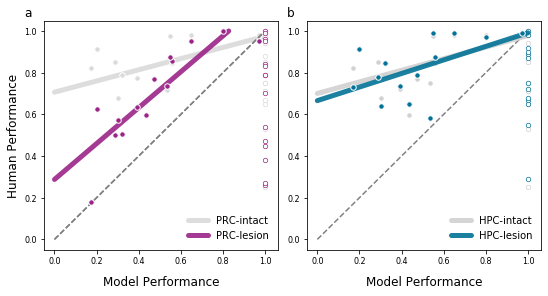

In [92]:
meta_analytic_results(it_layer, 
                      nondiagnostic['flat']['intact'], 
                      nondiagnostic['flat']['lesion'], 
                      nondiagnostic['flat']['control']) 

### A "V4-like" model layer also predict the behavior of PRC-intact subjects

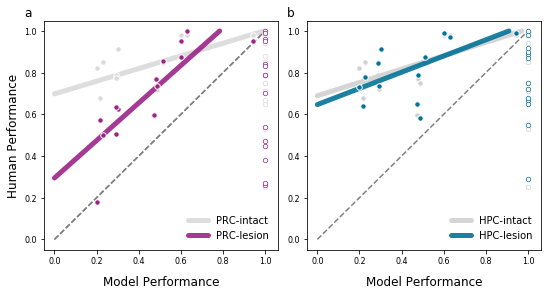

In [93]:
meta_analytic_results(v4_layer,
                      nondiagnostic['flat']['intact'], 
                      nondiagnostic['flat']['lesion'], 
                      nondiagnostic['flat']['control']) 

In [94]:
pls_fits['delta']

array([-0.33713237, -0.33052783, -0.30254698, -0.31201824, -0.27956173,
       -0.27183885, -0.22166746, -0.23084546, -0.15547754, -0.1111334 ,
       -0.05740935, -0.03486632,  0.06387811,  0.12668262,  0.14044398,
        0.15106274,  0.20275476,  0.22931552,  0.21621559])

# Focal Anatomical Dependencies

In [95]:
def annotate(region): 
    _xy = pls_fits[region]['mu']
    plt.annotate("'%s-like'"%region.upper(), 
                 xy=(argmax(_xy)-.8, max(_xy)+.08), 
                 size=7, rotation=0, color='grey')
    plt.scatter(x=argmax(_xy), y=max(_xy), 
                marker='|', color='black', s=200, linewidth=.5)
    
def layer_plot(layer_fit, ax): 
    
    v4_color='black'
    it_color='black'
    n_layers = len(layer_fit['layers'])
    alpha=.1
    
    v4 = layer_fit['v4']
    it = layer_fit['it']
    delta = layer_fit['delta']
    
    # V4 
    plt.plot(v4['mu'], color=v4_color, linestyle='--', linewidth=1, alpha=1, label='V4') 
    v4_min = v4['mu']-(v4['std']/np.sqrt(n_layers))
    v4_max = v4['mu']+(v4['std']/np.sqrt(n_layers))
    
    plt.fill_between(x=range(n_layers),y1=v4_min, y2=v4_max, 
                     color=v4_color, alpha=alpha, edgecolor='')
    
    annotate('v4')
    
    # IT 
    plt.plot(it['mu'], color=it_color, linestyle='-', linewidth=1, alpha=1, label='IT') 
    it_min = it['mu']-(it['std']/np.sqrt(n_layers))
    it_max = it['mu']+(it['std']/np.sqrt(n_layers))
    
    plt.fill_between(x=range(n_layers),y1=it_min, y2=it_max, 
                     color=it_color, alpha=alpha, edgecolor='')

    annotate('it')
    
    # DELTA 
    import matplotlib.patheffects as pe
    params = {'solid_capstyle':'round', 'linewidth':5, 'zorder':1,}
    plt.plot(range(n_layers), delta, color='white', 
             path_effects=[matplotlib.patheffects.Stroke(linewidth=3, foreground='black'), pe.Normal()], 
             label='$\Delta_{IT - V4}$')
    plt.ylim(min(delta)-.1, max(v4['mu'])+.15)
    
    # AESTHETICS
    plt.yticks(size=6)
    plt.ylabel('Cross-validated fit to Neural Data', labelpad=0, fontsize=11)
    plt.xlabel("Model Layer", labelpad=5, fontsize=10)
    plt.xticks(range(n_layers), pls_fits['layers'], rotation=90, fontsize=7);
    plt.legend(framealpha=0, fontsize=9, title_fontsize=9,loc=4)

In [96]:
def show_layer_fit(i_layer, group, show_x=0, show_y=0, show_tag=0): 
    
    xleg = {'pool1':'(Pre \'V4-like\' Layer)', 
            'pool3':'(\'V4-like\' Layer)', 
            'conv5_1': '(\'IT-like\' Layer)' ,
            'fc7':'(Latter \'IT-like\' Layer)'}
    
    y_tag = 'Human Performance'#%group.upper()
    l_tag = '%s-lesioned'%group.upper()
    x_layer = meta_df[i_layer].values
    y_intact = meta_df['%s_intact'%group].values
    y_lesion = meta_df['%s_lesion'%group].values
    i_color = meta_statistics['%s_colors'%group].values[np.nonzero( meta_statistics.layer.values == i_layer )[0][0]]

    l_line = LinearRegression().fit(np.reshape(x_layer, (-1,1)), np.reshape(y_lesion, (-1, 1)))
    i_line = LinearRegression().fit(np.reshape(x_layer, (-1,1)), np.reshape(y_intact, (-1, 1)))
    params = {'facecolor':i_color, 'edgecolor':'white', 's':5, 'linewidth':.2, 'zorder':10}

    plt.scatter(x = x_layer, y = y_lesion, **params)
    plt.plot((0, 1), (0, 1), color='grey', linestyle='--', linewidth=.6, alpha=.5) 

    line_params = {'solid_capstyle':'round', 'linewidth':3}
    xs = np.array([0, min(1 , ( ( 1 - l_line.intercept_[0] ) / l_line.coef_[0] ))] ) 
    plt.plot(xs, xs * l_line.coef_[0] + l_line.intercept_[0], color=i_color, **line_params, label='patient')
    intact_params = {'color': 'lightgrey', 'alpha':1, 'zorder':-5}

    xs = np.array([0, min(1 , ( ( 1 - i_line.intercept_[0] ) / i_line.coef_[0] ))] ) 
    plt.plot(xs, xs * i_line.coef_[0] + i_line.intercept_[0], **line_params, **intact_params)
    plt.plot([], [] , **line_params, **intact_params,label='control')
    plt.scatter(x = x_layer, y = y_intact, facecolor='lightgrey',s=5, linewidth=.5, edgecolor='', zorder=-2)

    if show_y: 
        plt.yticks([0.0, .5, 1.0], [0.0, .5, 1.0], size=7)
        plt.ylabel('%s'%y_tag, labelpad=5, fontsize=9, x=10)
        plt.legend( loc=4, framealpha=0, fontsize=7, title_fontsize=7, title=l_tag)
    else: 
        plt.yticks([])
    
    plt.ylim([-.1, 1.1]); plt.xlim([-.1, 1.1])
    if group=='hpc': 
        plt.xticks(fontsize=7)
        plt.xlabel('Model$_{%s}$ Performance\n %s' %(i_layer, xleg[i_layer]), labelpad=7, fontsize=9)
    else: 
        plt.xticks([])

In [101]:
def gradient_show(): 
    
    y_start = .063
    prc_offset = .007
    y_center=.0015
    x_start = -.30
    x_shift = .09
    l_fontsize=6

    colors = [i.rgb for i in colour.Color('#4B0082').range_to(colour.Color('#FF1493'), 20)]
    [plt.plot(np.array([i, i+1])/300+x_start,(y_start+prc_offset, y_start+prc_offset), color=colors[i], linewidth=4) for i in range(len(colors))]; 
    plt.annotate('PRC', xy=(x_start+x_shift, y_start+prc_offset-y_center), fontsize=l_fontsize)
    cs = [i.rgb for i in colour.Color('darkblue').range_to(colour.Color('#00FFFF'), 20)]
    [plt.plot(np.array([i, i+1])/300+x_start,(y_start, y_start), color=cs[i], linewidth=4) for i in range(len(cs))]; 
    plt.annotate('HPC', xy=(x_start+x_shift,y_start-y_center), fontsize=l_fontsize)
    plt.annotate('Lesion Group', xy=(x_start-.035, y_start+prc_offset*2), fontsize=l_fontsize)
    

def nice_legends(meta_statistics): 
    plt.scatter([], [], s=20,  linewidth=.7, facecolor='white', edgecolor='black', label='p$_{corrected}$ < 0.05')
    #plt.scatter([], [], **plot_params, **color_params, facecolor='white', edgecolor='lightgrey', label='non-significant')
    plt.legend(title='Interaction', framealpha=0, title_fontsize=l_fontsize, fontsize=l_fontsize-1, 
               loc=3, bbox_to_anchor=[.45, .335]) # 'Interaction ('r'$\alpha$''=.05)'

    for region in ['it', 'v4']: 

        i_layer = {'it':it_layer, 'v4':v4_layer}[region]
        i_index = np.nonzero(np.array(pls_fits['layers']) == i_layer)[0][0]

        __y = meta_statistics[meta_statistics.layer==i_layer].prc_delta_rmse.values[0]
        __x = pls_fits['delta'][i_index]
        
        y_offset = __y+[-.02, .02][region=='v4']
        plt.annotate("'%s-like' Layer"%region.upper(), 
                     xy=(__x-.06, y_offset), fontsize=l_fontsize, color='grey',  
                     bbox={'alpha':1, 'color':'white'})
        plt.plot([__x, __x], [__y, y_offset], linewidth=.5, alpha=.3, linestyle=":", zorder=-3, color='black')

### relate model, electrophysiological, and retrospective data

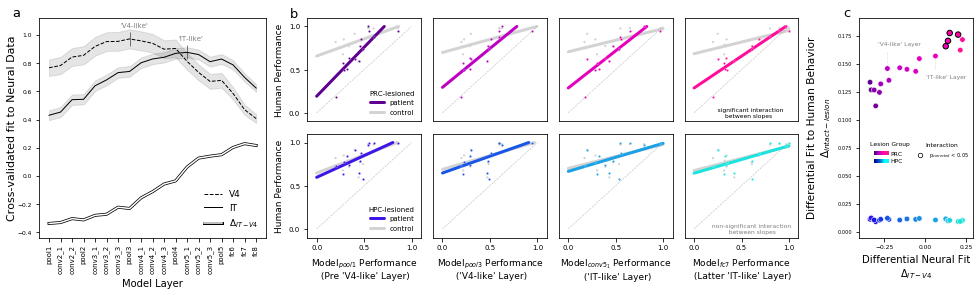

In [105]:
fig = plt.figure(constrained_layout=True, figsize=[13.5, 4])
gs = fig.add_gridspec(2, 8) 

# MODEL FITS TO ELECTROPHYSIOLOGICAL DATA
ax = fig.add_subplot(gs[0:2, 0:2]); 
order = pls_fits['layers']
layer_plot(pls_fits, ax) 
ax.text(-0.08, 1.05, 'a', transform=ax.transAxes, fontsize=13, va='top', ha='right')

# LAYER FITS TO PRC-LESIONED PERFORMENCE
f_ax = fig.add_subplot(gs[0:1, 2:3])
show_layer_fit('pool1', 'prc', show_y=1)
f_ax.text(-0.08, 1.10, 'b', transform=f_ax.transAxes,fontsize=13, va='top', ha='right')
f_ax = fig.add_subplot(gs[0:1, 3:4])
show_layer_fit('pool3', 'prc', show_tag=1)
f_ax = fig.add_subplot(gs[0:1, 4:5])
show_layer_fit('conv5_1', 'prc')
f_ax = fig.add_subplot(gs[0:1, 5:6])
show_layer_fit('fc7', 'prc')
plt.annotate('    significant interaction \n        between slopes', 
             xy=(.17, -.05), fontsize=6, color='black')

# LAYER FITS TO HPC-LESIONED PERFORMENCE
f_ax = fig.add_subplot(gs[1:2, 2:3])
show_layer_fit('pool1', 'hpc', show_x=1, show_y=1)
f_ax = fig.add_subplot(gs[1:2, 3:4])
show_layer_fit('pool3', 'hpc', show_x=1, show_tag=1)
f_ax = fig.add_subplot(gs[1:2, 4:5])
show_layer_fit('conv5_1','hpc', show_x=1, show_tag=1)
f_ax = fig.add_subplot(gs[1:2, 5:6])
show_layer_fit('fc7', 'hpc')
plt.annotate(' non-significant interaction \n          between slopes ', 
             xy=(.17, -.05), fontsize=6, color='grey')

# RELATING ELECTROPHYSIOLOGICAL DATA TO HUMAN BEHAVIOR
f_ax = fig.add_subplot(gs[0:2, 7:8])
f_ax.text(-0.08, 1.05, 'c', transform=f_ax.transAxes,fontsize=13, va='top', ha='right')

# only extract human fits to model layers that have fits to electrophysiological data
_meta = meta_statistics[np.nonzero(meta_statistics.layer == pls_fits['layers'][0])[0][0]:] 

# params for both plots
i_size = 30
l_fontsize=6
plot_params = {'marker':'o', 's':i_size}
color_params = {'linewidth':.5}
_plsfits = pls_fits['delta']
x_label_size = 12

#### PRC DATA 
alphas = (.05/len(pls_fits['it']['mu']))
p_corrected = np.array(_meta['prc_interaction']) < alphas
_prc = _meta['prc_intact_rmse'] - _meta['prc_lesion_rmse']
sig_line = [['white', 'black'][i==True] for i in p_corrected]
lwidth = [[.5,1][i==True] for i in p_corrected]
plt.scatter(_plsfits, _prc, **plot_params, linewidth=lwidth, 
            facecolor=_meta['prc_colors'], edgecolor=sig_line)

#### HPC DATA 
p_corrected = np.array(_meta['hpc_interaction']) < _alpha 
sig_line = [['white', 'black'][i==True] for i in p_corrected]
_hpc = _meta['hpc_intact_rmse'] - _meta['hpc_lesion_rmse']
plt.scatter(_plsfits, _hpc, **plot_params, **color_params, 
            facecolor=_meta['hpc_colors'], edgecolor=sig_line)
 
### AESTHETICS 
plt.xticks(size=6)
plt.yticks(fontsize=5)
x_label = 'Differential Neural Fit\n$\Delta_{IT - V4}$'
plt.xlabel(x_label, fontsize=10, labelpad=5)
plt.ylabel('Differential Fit to Human Behavior\n$\Delta_{intact-lesion}$', 
           fontsize=10.5, labelpad=5) 
plt.ylim(-.005, .191)

gradient_show()
nice_legends(_meta)
save_location = os.path.join(_location, 'focal_vvs_dependence.pdf')
plt.savefig(save_location, format='pdf', bbox_inches = "tight")

## Novel diagnostic experiment

In [113]:
with open('electrophysiological/summaries.pkl', 'rb') as handle:
    summaries = pickle.load(handle)

In [114]:
_X = [] 
_Y = [] 
_L = [] 
_C = [] 
selected_categories = [ 'Faces', 'Planes', 'Chairs',   'Animals'] # list( summaries )# 
for i_category in list( summaries ): 
    for i_typical in summaries[i_category]: 
        for i_oddity in summaries[i_category][i_typical]: 
            _Y.append(np.mean(summaries[i_category][i_typical][i_oddity]['linear_accuracy']))
            _X.append(np.mean(summaries[i_category][i_typical][i_oddity]['distance_accuracy']))
            _L.append(i_typical)
            _C.append(i_category)

In [115]:
_unweighted_transform = LinearRegression().fit(np.reshape(_X, (-1,1)), np.reshape(_Y, (-1, 1)))

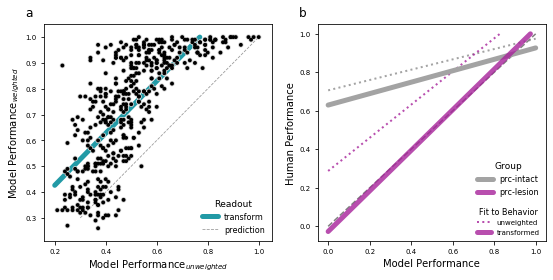

In [116]:
def plot_nice_line(model_, params={}, lim=0, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([lim, min(1 , ( ( 1 - b) / m ))])  
    plt.plot(xs, xs * m + b, **params)
        
lw = 5
label_size = 9
label_height = 1.03
label_dist = -.14

###
fig = plt.figure(figsize=[9,4])
ax = fig.add_subplot(121)
plt.scatter(x=_X, y=_Y, facecolor='lightgrey', edgecolor='', linewidth=0, s=30)
plt.scatter(x=_X, y=_Y, facecolor='black', edgecolor='', linewidth=.2, s=15)
plot_nice_line(_unweighted_transform, 
               {'linewidth':lw, 'alpha':1, 'color':'#229aa6', 'solid_capstyle': 'round', 'zorder':-5, 
                'label':'transform'}, 
               lim=.2)
[plt.scatter([], [], )]
#plt.legend()
prc_color = ('#a6229a', '#72249a') [0]
prc_old = '#b2b2b2'
hpc_color = '#a3a3a3'#('#032997', '#037397') [1]
#plt.plot([.3, .3], [.2, 1], linestyle=':', color='grey', linewidth=.5, zorder=-1)
#plt.plot([.2, 1], [.3, .3], linestyle=':', color='grey', linewidth=.5, zorder=-1, label='chance')
plt.xlabel(r'Model Performance$_{unweighted}$')
plt.ylabel(r'Model Performance$_{weighted}$')
plt.plot([.3, 1], [.3, 1], linestyle='--', color='grey', zorder=-3, label='prediction', linewidth=.8, alpha=.8)
plt.xticks(fontsize=7);
plt.yticks(fontsize=7);

plt.legend(framealpha=0, fontsize=8, title='Readout', title_fontsize=9)
ax.text(-0.05, 1.08, ['a','b','c'][0], transform=ax.transAxes,fontsize=12, va='top', ha='right')

    

ax = fig.add_subplot(122)
_x = meta_df[it_layer].values
_y = meta_df['prc_lesion'].values
linestyle = ':'


_model = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, {'color':prc_color, 'linestyle':linestyle, 
                        'linewidth':lw-3, 'label':'unweighted', 'zorder':1, 'alpha':.8, 'solid_capstyle': 'round'})
transformed_x = [min(i[0], 1) for i in list(_unweighted_transform.predict(np.expand_dims(meta_df[it_layer], 1)))]

_model = LinearRegression().fit(np.reshape(transformed_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, {'color':prc_color, 'alpha':1, 'linewidth':lw,
                        'label':'transformed', 'alpha':.8, 'solid_capstyle': 'round', 'zorder':3})
transformed_legend = plt.legend(framealpha=0, loc=4, title='Fit to Behavior', title_fontsize=8, fontsize=7) 



_y = meta_df['prc_intact'].values
_model = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, {'color':hpc_color, 'alpha':1, 'linewidth':lw-3, 'linestyle':linestyle, 
                        'zorder':-3, 'solid_capstyle': 'round'})
_model = LinearRegression().fit(np.reshape(transformed_x, (-1,1)), np.reshape(_y, (-1, 1)))

plot_nice_line(_model, {'color':hpc_color, 'alpha':.8,  'linewidth':lw, 
                        'alpha':1, 'zorder':2, 'solid_capstyle': 'round', })

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-3,)
plt.xlabel('Model Performance')
plt.ylabel('Human Performance')
plt.xticks(fontsize=7);
plt.yticks(fontsize=7);

ax.text(-0.05, 1.08, ['a','b','c'][1], transform=ax.transAxes,fontsize=12, va='top', ha='right')

# # Add first legend:  only labeled data is included
# leg1 = ax.legend(loc='lower left')
# # Add second legend for the maxes and mins.
# # leg1 will be removed from figure
# leg2 = ax.legend([maxline,minline],['max','min'], loc='upper right')
# # Manually add the first legend back
# ax.add_artist(leg1)

_a, = plt.plot([],[], **{'color':prc_color, 'alpha':.8, 'linewidth':lw,
                        'label':'transformed', 'solid_capstyle': 'round', 'zorder':-5})

_b, = plt.plot([],[], **{'color':hpc_color, 'alpha':1, 'linewidth':lw, 
                        'alpha':1, 'zorder':1, 'solid_capstyle': 'round'})


leg2 = ax.legend([_b,_a],['prc-intact', 'prc-lesion'], bbox_to_anchor=[1, .40], title='Group', 
                framealpha=0, title_fontsize=9, fontsize=8)

ax.add_artist( transformed_legend )
save_location = os.path.join(_location, 'weighted_unweighted_transform.pdf')
plt.savefig(save_location, format='pdf', bbox_inches = "tight")

In [117]:
transformed_x = [min(i[0], 1) for i in list(_unweighted_transform.predict(np.expand_dims(meta_df[it_layer], 1)))]
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((transformed_x, meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_lesion'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
prcinteraction = smf.ols("human ~ model + group", tmpdf).fit()
show_model_parameters(prcinteraction)[1]

'$R^{2}_{model} = 0.78$, $\\beta = 0.94$, $F(2, 25)$ = $9.29, p < 2 $ x $ 10 ^{-9} $'

In [118]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((transformed_x, meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_lesion'])),
     'group': np.concatenate([np.repeat('transformed',n_), np.repeat('original', n_)])})
prcinteraction = smf.ols("human ~ model + group", tmpdf).fit()
show_model_parameters(prcinteraction, -2)[1]

'$R^{2}_{model} = 0.78$, $\\beta = -0.20$, $F(2, 25)$ = $-4.29, p < 3 $ x $ 10 ^{-4} $'

In [119]:
uniform = np.array(_X)
nonuniform = np.array(_Y)

In [120]:
print( np.mean(np.diff(uniform[uniform.argsort()])), min(uniform), max(uniform) ) 

0.001767337807606264 0.21 1.0


In [121]:
print( np.mean(np.diff(nonuniform[nonuniform.argsort()])), min(nonuniform), max(nonuniform))

0.0016554809843400448 0.26 1.0


In [122]:
selected_x = np.array([_X[i] for i in range(len(_X)) if _C[i] in selected_categories])
selected_y = np.array([_Y[i] for i in range(len(_X)) if _C[i] in selected_categories])

In [127]:
# print( np.mean(np.diff(selected_x[selected_x.argsort()])), min(selected_x), max(selected_x) ) 
# print( np.mean(np.diff(selected_y[selected_y.argsort()])), min(selected_y), max(selected_y) ) 

In [129]:
ls high-throughput/

human_performance.csv   online_data_collection/


In [130]:
novel = pandas.read_csv('high-throughput/human_performance.csv')

In [131]:
novel['delta_it_v4'] = novel['it']-novel['v4'] 
novel['delta_prc_it'] = novel['human']-novel['it'] 
novel['delta_fc6_v4'] = novel['fc6']-novel['v4'] 
novel['delta_prc_fc6'] = novel['human']-novel['fc6'] 

In [132]:
#novel_summary = novel.groupby(['typical_name']).mean()
novel_summary = pandas.DataFrame({
    'it': np.array([novel[novel.typical_name==o]['it'].mean()  for o in novel.typical_name.unique()]), 
    'v4': np.array([novel[novel.typical_name==o]['v4'].mean()  for o in novel.typical_name.unique()]),
    'fc6': np.array([novel[novel.typical_name==o]['fc6'].mean()  for o in novel.typical_name.unique()]),
    'prc': np.array([novel[novel.typical_name==o]['human'].mean()  for o in novel.typical_name.unique()]),
    'rt': np.array([np.round(novel[novel.typical_name==o]['rt'].mean()) for o in novel.typical_name.unique()]), 
    'object': np.array([o for o in novel.typical_name.unique()]),
    'category': [novel[novel.typical_name==o]['category'].iloc[0] for o in novel.typical_name.unique()]
})

novel_summary['delta_prc_it'] = novel_summary['prc']-novel_summary['it']
novel_summary['delta_prc_fc6'] = novel_summary['prc']-novel_summary['fc6'] 
novel_summary['delta_it_v4'] = novel_summary['it']-novel_summary['v4'] 
novel_summary['delta_prc_v4'] = novel_summary['prc']-novel_summary['v4'] 
novel_summary['delta_fc6_v4'] = novel_summary['fc6']-novel_summary['v4'] 

nN = len(novel_summary)

### IT outperforms V4

In [133]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_it_v4 ~ 1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.18$, $F(0, 31)$ = $6.56, p < 3 $ x $ 10 ^{-7} $

### PRC outperforms IT

In [134]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_prc_it ~ 1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.24$, $F(0, 31)$ = $9.50, p < 1 $ x $ 10 ^{-10} $

### model predicts IT

In [135]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("it ~ fc6", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

$R^{2}_{model} = 0.86$, $\beta = 0.81$, $F(1, 30)$ = $13.33, p < 4 $ x $ 10 ^{-14} $

### model outperforms V4

In [136]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_fc6_v4 ~ 1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.26$, $F(0, 31)$ = $8.02, p < 5 $ x $ 10 ^{-9} $

### PRC outperforms model

In [137]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_prc_fc6~1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

$R^{2}_{model} = 0.00$, $\beta = 0.16$, $F(0, 31)$ = $5.38, p < 8 $ x $ 10 ^{-6} $

In [138]:
novel_interaction_data = pandas.DataFrame({
    'accuracy': np.concatenate([novel_summary['v4'],novel_summary['it'], novel_summary['prc']]), 
    'vvs_region': np.concatenate([np.repeat('v4', nN),np.repeat('it', nN), np.repeat('prc', nN)]), 
    'model': np.concatenate([novel_summary['fc6'],novel_summary['fc6'], novel_summary['fc6']]), 
})

In [139]:
# test for interaction by patient group 
novel_interaction_test = smf.ols("accuracy ~ vvs_region * model", novel_interaction_data).fit()
show_model_parameters(novel_interaction_test)[0]

$R^{2}_{model} = 0.90$, $\beta = -0.56$, $F(5, 90)$ = $-6.75, p < 2 $ x $ 10 ^{-9} $

In [140]:
rt_delta = smf.ols("zscore(it) ~ -1 + zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

$R^{2}_{model} = 0.77$, $\beta = -0.88$, $F(1, 31)$ = $-10.16, p < 3 $ x $ 10 ^{-11} $

In [141]:
rt_delta = smf.ols("zscore(v4) ~ zscore(rt)-1", novel_summary).fit()
show_model_parameters(rt_delta)[0]

$R^{2}_{model} = 0.17$, $\beta = -0.42$, $F(1, 31)$ = $-2.55, p < .05 $

In [142]:
rt_delta = smf.ols("zscore(delta_prc_it) ~ -1 + zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

$R^{2}_{model} = 0.65$, $\beta = 0.81$, $F(1, 31)$ = $7.56, p < 2 $ x $ 10 ^{-8} $

In [143]:
rt_delta = smf.ols("zscore(delta_prc_v4) ~ zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

$R^{2}_{model} = 0.01$, $\beta = -0.08$, $F(1, 30)$ = $-0.41, p > .05$

In [144]:
rt_delta = smf.ols("zscore(delta_prc_fc6) ~ -1 + zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

$R^{2}_{model} = 0.51$, $\beta = 0.72$, $F(1, 31)$ = $5.72, p < 3 $ x $ 10 ^{-6} $

In [145]:
rt_delta = smf.ols("zscore(delta_prc_fc6) ~ zscore(rt)-1", novel_summary).fit()
show_model_parameters(rt_delta)[0]

$R^{2}_{model} = 0.51$, $\beta = 0.72$, $F(1, 31)$ = $5.72, p < 3 $ x $ 10 ^{-6} $

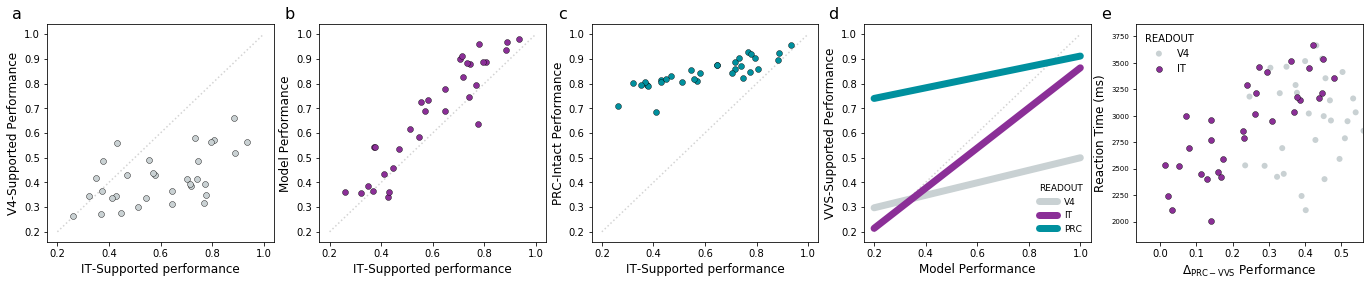

In [146]:
def plot_nice_line(model_, params={}, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([.2, min(1 , ( ( 1 - b) / m ))])  
    plt.plot(xs, xs * m + b, **params)
    
color = { 'v4':'#c9d1d3', 'fc6': '#8b2f97', 'prc': '#00909e'}

plt.figure(figsize=[17, 4])
for plot, region in enumerate(list(color), 1):
    
    ax = plt.subplot(1, 5, plot)
    #ax = fig.add_subplot(2,2,i+1)
    x_ = novel_summary['it'].values
    y_ = novel_summary[region].values
    plt.plot([.2, 1], [.2, 1], color='lightgrey', linestyle=':', zorder=-1)
    _dotparams = {'edgecolor':'black', 'linewidth': .4, 's':35, 'color':color[region]}
    plt.scatter(x=x_, y=y_, **_dotparams)
    plt.xlabel('IT-Supported performance', fontsize=12)
    if region == 'fc6': 
        plt.ylabel('Model Performance', fontsize=12)        
    elif region == 'prc': 
        plt.ylabel('PRC-Intact Performance', fontsize=12)      
    else: 
        plt.ylabel('%s-Supported Performance'%region.upper(), fontsize=12)
    
    ax.text(-0.11, 1.08, ['','a','b','c'][plot], transform=ax.transAxes,fontsize=16, va='top', ha='right')
        
    ax = plt.subplot(1, 5, 4)
    _lineparams = {'linewidth':7, 'zorder':-1, 'color':color[region], 'label':region.upper(), 
                   'solid_capstyle': 'round'}
    
    x_ = novel_summary['fc6'].values
    if region == 'fc6': 
        y_ = novel_summary['it'].values
        _lineparams['label']='IT'
    else: 
        y_ = novel_summary[region].values
        
    _model = LinearRegression().fit(np.reshape(x_, (-1,1)), np.reshape(y_, (-1, 1)))
    plot_nice_line(_model, _lineparams)

plt.ylabel('VVS-Supported Performance', fontsize=12)    
plt.xlabel('Model Performance', fontsize=12)
plt.plot([.2, 1], [.2, 1], color='lightgrey', linestyle=':', zorder=-3) 
plt.legend(loc=4, title='READOUT', framealpha=0, fontsize=9, title_fontsize=9) 
ax.text(-0.11, 1.08, 'd', transform=ax.transAxes,fontsize=16, va='top', ha='right')
ax = plt.subplot(155)
_dotparams = {'edgecolor':'black', 'linewidth': .4, 's':35}
_x = novel_summary['delta_prc_it']
_y = novel_summary['rt']
plt.scatter(x=novel_summary['delta_prc_v4'], y=_y, facecolor=color['v4'], edgecolor='', label='V4', zorder=-2)
plt.scatter(x=_x, y=_y, color=color['fc6'], **_dotparams, label='IT')
plt.ylim(min(_y)-200,  max(_y)+200)
plt.xlim(min(_x)-.08,  max(_x)+.08)
plt.legend(framealpha=0, title='READOUT') 
#plt.xlabel('PRC-intact — VVS-supported Accuracy', fontsize=12)
plt.xlabel('$\Delta_{\mathregular{PRC-VVS}}$'' Performance', fontsize=12)
plt.ylabel('Reaction Time (ms)', fontsize=12,)
plt.yticks(size=7)
plt.subplots_adjust(right=1.2)
ax.text(-0.11, 1.08, 'e', transform=ax.transAxes,fontsize=16, va='top', ha='right')

save_location = os.path.join(_location, 'novel_diagnostic_experiment.pdf')
plt.savefig(save_location, format='pdf', bbox_inches = "tight")

In [147]:
show_model_parameters(novel_interaction_test, -3)[0]

$R^{2}_{model} = 0.90$, $\beta = 0.81$, $F(5, 90)$ = $13.86, p < 5 $ x $ 10 ^{-24} $

In [148]:
show_model_parameters(novel_interaction_test, -2)[0]

$R^{2}_{model} = 0.90$, $\beta = -0.60$, $F(5, 90)$ = $-7.21, p < 2 $ x $ 10 ^{-10} $

In [151]:
show_model_parameters(novel_interaction_test)[0]

$R^{2}_{model} = 0.90$, $\beta = -0.56$, $F(5, 90)$ = $-6.75, p < 2 $ x $ 10 ^{-9} $

In [153]:
ls in_silico/architecture/

README.md             retrospective.pickle
resnet_prep.ipynb     retrospective.py


In [154]:
resnet_file = 'in_silico/architecture/retrospective.pickle'
with open(resnet_file, 'rb') as handle: 
    resnets = pickle.load(handle)
    for i_resnet in list(resnets): 
        meta_df['resnet_%s'%i_resnet] = [resnets[i_resnet][i] for i in meta_df.experiment.values]

### Fit to PRC-lesioned or -intact subjects doesn't change by increasing model depth

In [231]:
show_model_parameters( 
    smf.ols('y~-1 + x', data=pandas.DataFrame({'x':_singleMu,
                                               'y': np.arange(0, len(_singleMu))})).fit() )[1]

'$R^{2}_{model} = 0.62$, $\\beta = 6.74$, $F(1, 4)$ = $2.56, p > .05$'

In [232]:
show_model_parameters( 
    smf.ols('y~-1 + x', data=pandas.DataFrame({'x':_singleBeta, 'y': np.arange(0, len(_singleMu))})).fit())[1]

'$R^{2}_{model} = 0.68$, $\\beta = 8.04$, $F(1, 4)$ = $2.91, p < .05 $'

In [158]:
resnet_ttest = smf.ols(formula = 'prc_intact ~ model_performance + linear', data=resnet_test).fit()
show_model_parameters(resnet_ttest)[0]

$R^{2}_{model} = 0.31$, $\beta = -0.00$, $F(2, 67)$ = $-0.24, p > .05$

In [159]:
resnet_ttest.params

Intercept            0.699159
model_performance    0.252420
linear              -0.002061
dtype: float64

### All model depths demonstrate a significant interaction between PRC-lesioned and -intact subjects

In [160]:
resnet_test = pandas.DataFrame()
counter = 0
for i_resnet in list(resnets): 
    for i_group in ['prc_intact', 'prc_lesion']: 
        _df = pandas.DataFrame({'resnet':meta_df['resnet_%s'%i_resnet], 
                                'group':np.repeat([0,1][i_group=='prc_intact'], len(meta_df)),
                                'human':meta_df[i_group],
                                'architecture': np.repeat(i_resnet, len(meta_df))})
        resnet_test = pandas.concat([resnet_test, _df], ignore_index=True)

In [161]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='18']).fit()
show_model_parameters(_restest)[0]

$R^{2}_{model} = 0.75$, $\beta = -0.51$, $F(3, 24)$ = $-3.32, p < 3 $ x $ 10 ^{-3} $

In [162]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='34']).fit()
show_model_parameters(_restest)[0]

$R^{2}_{model} = 0.74$, $\beta = -0.45$, $F(3, 24)$ = $-3.07, p < 6 $ x $ 10 ^{-3} $

In [163]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='50']).fit()
show_model_parameters(_restest) [0]

$R^{2}_{model} = 0.71$, $\beta = -0.49$, $F(3, 24)$ = $-3.25, p < 4 $ x $ 10 ^{-3} $

In [164]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='101']).fit()
show_model_parameters(_restest) [0]

$R^{2}_{model} = 0.76$, $\beta = -0.56$, $F(3, 24)$ = $-3.66, p < 2 $ x $ 10 ^{-3} $

In [165]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='152']).fit()
show_model_parameters(_restest) [0]

$R^{2}_{model} = 0.78$, $\beta = -0.54$, $F(3, 24)$ = $-3.97, p < 6 $ x $ 10 ^{-4} $

In [171]:
def show_resnets(df):
    
    def plot_nice_line(model_, params={}, title=''): 
        m, b = model_.coef_[0], model_.intercept_[0]
        xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
        plt.plot(xs, xs * m + b, **params)
        
    prc_color = ('#a6229a', '#72249a') 
    con_color = ('#d8d8d8', '#b2b2b2')   
    hpc_color = ('#032997', '#037397') 
    
    lw = 3
    _a = 1 
    _cap = ['butt', 'round', 'projecting'][0]
    _jstyle = ['miter', 'round', 'bevel'][2]
    resnets = [i for i in meta_df.columns if 'resnet' in i]
    prc_c = [i.rgb for i in colour.Color(prc_color[0]).range_to(colour.Color(prc_color[1]), len(resnets))]
    hpc_c = [i.rgb for i in colour.Color(hpc_color[0]).range_to(colour.Color(hpc_color[1]), len(resnets))]
    con_c = [i.rgb for i in colour.Color(con_color[0]).range_to(colour.Color(con_color[1]), len(resnets))]

    prc_ = df['prc_lesion'].values
    hpc_ = df['hpc_lesion'].values
    con_ = df['prc_intact'].values
    
    for i_resnet in range(len(resnets)): 
        
        mod_ = df[resnets[i_resnet]].values

        con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_, (-1, 1)))
        params = {'color':con_c[i_resnet],'linewidth':lw,'zorder':-10, 
                 'solid_capstyle':_cap, 'alpha':_a, 'solid_joinstyle':_jstyle}
        plot_nice_line(con_model_, params)

        hpc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(hpc_, (-1, 1)))
        params = {'color':hpc_c[i_resnet], 'linewidth':lw,'zorder':-3, 
                 'solid_capstyle':_cap, 'alpha':_a}
        plot_nice_line(hpc_model_, params)

        prc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(prc_, (-1, 1)))
        params = {'color':prc_c[i_resnet], 'linewidth':lw, 'zorder':-5, 'label':'%3d'%int(resnets[i_resnet][7:]), 
                 'solid_capstyle':_cap, 'alpha':_a}
        plot_nice_line(prc_model_, params)
    
    
    y_i = .0085
    y_x = .0595
    ly = .29
    _params = {'solid_capstyle':_cap,'linewidth':lw}
    # PRC ANNOTATION
    plt.annotate('$PRC$', xy=(.825, ly), fontsize=9)
    # HPC ANNOTATION
    [plt.plot([.71, .79],[y_i + y_x*i, y_i+y_x*i], color=hpc_c[i], **_params) for i in range(len(resnets))]
    plt.annotate('$HPC$', xy=(.715, ly), fontsize=9)
    # PRC INTACT
    [plt.plot([.60, .68],[y_i + y_x*i, y_i+y_x*i], color=con_c[i], **_params) for i in range(len(resnets))]
    plt.annotate('$NON$', xy=(.59, ly), fontsize=9)
    plt.annotate('$n$', xy=(.96, ly), fontsize=9)
    plt.annotate('Lesion Group', xy=(.62, .37), fontsize=10)
    plt.plot([0, 1], [0, 1], color='grey', linestyle=':', zorder=-15)
    plt.legend(title='', framealpha=0, fontsize=8, loc=4)
    plt.xlabel('Model$_{layers=n} $'' ''Performance', fontsize=12, labelpad=10)
    plt.ylabel('Human Performance', fontsize=12)
    plt.xticks(size=8)
    plt.yticks(size=8)

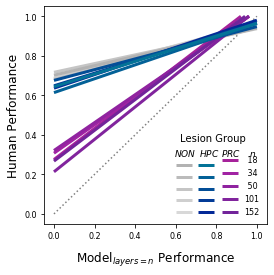

In [173]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)
show_resnets(meta_df)
plt.savefig(os.path.join(_location, 'multiple_resnets.pdf'), 
            format='pdf', bbox_inches = "tight")

In [212]:
md(r'$\mu_{prc.improved}=%.02f, \mu_{prc.unimproved}=%.02f$'%(np.mean( _improved ), np.mean(_static)))

$\mu_{prc.improved}=nan, \mu_{prc.unimproved}=nan$

In [213]:
stats.ttest_ind(_improved, _static, equal_var=False,)

Ttest_indResult(statistic=nan, pvalue=nan)

In [214]:
_df = pandas.DataFrame({'model': np.array([meta_df['conv2_1'].values, meta_df['fc6'].values]).flatten(), 
                        'human': np.array([meta_df['prc_lesion'].values, meta_df['prc_lesion'].values]).flatten(), 
                        'tag': np.array([np.repeat(0, len(meta_df)), np.repeat(1, len(meta_df))]).flatten()})
show_model_parameters(smf.ols(formula = 'human ~ model * tag', data=_df).fit())[0]

$R^{2}_{model} = 0.79$, $\beta = -0.75$, $F(3, 24)$ = $-2.91, p < 8 $ x $ 10 ^{-3} $

In [215]:
_df = pandas.DataFrame({'delta': np.array([meta_df['prc_lesion'].values-meta_df['conv2_1'].values,
                                           meta_df['prc_lesion'].values-meta_df['fc7'].values]).flatten(), 
                        'layer': np.array([np.repeat(0, len(meta_df)), np.repeat(1, len(meta_df))]).flatten()})
show_model_parameters(smf.ols(formula = 'delta ~ layer', data=_df).fit())[0]

$R^{2}_{model} = 0.17$, $\beta = -0.11$, $F(1, 26)$ = $-2.33, p < .05 $

### FACE ANALYSES

In [217]:
vggface_retrospective = 'in_silico/training/retrospective/facetrained_retrospective.pickle'
with open(vggface_retrospective, 'rb') as handle: 
    vgg_face = pickle.load(handle)
    meta_df['vggface'] = [vgg_face[i] for i in meta_df.experiment.values]
    meta_df['isface'] = ['face' in i for i in meta_df.experiment.values]
meta_face = meta_df[meta_df['isface']]
meta_objects = meta_df[meta_df['isface']==False]

In [218]:
_facenovel = 'in_silico/training/novel/multiple_models_novel_stimuli.csv'
df_select = pandas.read_csv(_facenovel)
_f = df_select

foveated_items = pandas.DataFrame({ 
    #'human': _f[_f.model=='human'].accuracy.values, 
    #'time': _f[_f.model=='human'].reaction_time.values,
    'imagenet':_f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='imagenet')].accuracy.values,
    'vggface': _f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='vggface')].accuracy.values,
    'it': _f[(_f.model=='it')].accuracy.values, 
    'category': _f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='vggface')].category.values, 
    'typical_name': _f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='vggface')].typical_name.values
})

novel_objects = foveated_items[foveated_items.category!='faces']
novel_faces = foveated_items[foveated_items.category=='faces']

### Faces are "complex": PRC-intact subjects outperform -lesioned subjects, models, and IT

###  meta-analysis

In [219]:
_facetest = pandas.DataFrame({'delta':meta_face['prc_intact']-meta_face['prc_lesion']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_facetest).fit())[0]

$R^{2}_{model} = 0.00$, $\beta = 0.20$, $F(0, 3)$ = $4.25, p < .05 $

In [220]:
_facetest = pandas.DataFrame({'delta':meta_face['prc_intact']-meta_face['fc6']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_facetest).fit())[0]

$R^{2}_{model} = 0.00$, $\beta = 0.47$, $F(0, 3)$ = $9.42, p < 3 $ x $ 10 ^{-3} $

### novel-analysis

In [221]:
# _ttestface = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['imagenet']})
# show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

In [223]:
# _ttestface = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['it']})
# show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

### face training increases performance on faces

In [224]:
_ttestface = pandas.DataFrame({'delta':meta_face['vggface']-meta_face['fc6']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

$R^{2}_{model} = 0.00$, $\beta = 0.31$, $F(0, 3)$ = $4.88, p < .05 $

In [225]:
_ttestface = pandas.DataFrame({'delta':novel_faces['vggface']-novel_faces['imagenet']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[1]

'$R^{2}_{model} = 0.00$, $\\beta = 0.31$, $F(0, 279)$ = $26.22, p < 3 $ x $ 10 ^{-77} $'

### Model Performance is statistically indistinguishable for PRC-intact behavior

In [226]:
_ttestface = pandas.DataFrame({'delta':meta_face['prc_intact']-meta_face['vggface']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

$R^{2}_{model} = 0.00$, $\beta = 0.16$, $F(0, 3)$ = $1.91, p > .05$

In [227]:
# _ttestface = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['vggface']})
# show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

### face-trained models perform worse on non-faces

In [228]:
_facetest = pandas.DataFrame({'delta':meta_objects['vggface']-meta_objects['fc6']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_facetest).fit())[0]

$R^{2}_{model} = -0.00$, $\beta = -0.14$, $F(0, 9)$ = $-2.79, p < .05 $

In [229]:
_ttestface = pandas.DataFrame({'delta':novel_objects['imagenet']-novel_objects['vggface']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[1]

'$R^{2}_{model} = 0.00$, $\\beta = 0.16$, $F(0, 839)$ = $20.30, p < 8 $ x $ 10 ^{-75} $'

### significant interaction between training and testing performance, as a function of stimulus type

In [230]:
retro_test = pandas.DataFrame({'human': np.array([meta_df['prc_lesion'], meta_df['prc_lesion']]).flatten(), 
                               'model': np.array([meta_df['vggface'], meta_df['fc6']]).flatten(), 
                               'face': np.array([meta_df.isface==False, meta_df.isface==False]).flatten(), 
                               'type': np.array([np.repeat(0, len(meta_df)), np.repeat(1, len(meta_df))]).flatten()})

novel_test = pandas.DataFrame({
    'human': np.array([foveated_items['human'], foveated_items['human']]).flatten(), 
    'model': np.array([foveated_items['vggface'], foveated_items['imagenet']]).flatten(), 
    'face': np.array([foveated_items.category=='faces', foveated_items.category=='faces']).flatten(), 
    'type': np.array([np.repeat(0, len(foveated_items)), np.repeat(1, len(foveated_items))]).flatten()})

KeyError: 'human'

In [525]:
stats.ttest_rel(meta_df[meta_df.isface == True]['vggface'].values, 
                meta_df[meta_df.isface == True][it_layer].values) 

Ttest_relResult(statistic=7.91715350205103, pvalue=0.004201133532817599)

In [526]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=retro_test).fit()
show_model_parameters(_ttestface)[0]

0.01052553437667199


$R^{2}_{model} = 0.27$, $\beta = 0.47$, $F(3, 24)$ = $2.77, p < .05 $

In [527]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=novel_test).fit()
show_model_parameters(_ttestface)[0]

5.795337189424493e-20


$R^{2}_{model} = 0.20$, $\beta = -0.48$, $F(3, 426)$ = $-9.62, p < 6 $ x $ 10 ^{-20} $

In [505]:
show_model_parameters(smf.ols(formula = 'human ~ model + face *  type', data=retro_test).fit(), -2) [0]

0.004693417617607256


$R^{2}_{model} = 0.71$, $\beta = 0.32$, $F(4, 23)$ = $3.13, p < 5 $ x $ 10 ^{-3} $

In [317]:
_ttestface = smf.ols(formula = 'human ~ model + face *  type', data=novel_test).fit()
show_model_parameters(_ttestface)[0]

0.020642020550835267


$R^{2}_{model} = 0.26$, $\beta = 0.05$, $F(4, 425)$ = $2.32, p < .05 $

In [318]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=novel_test).fit()
show_model_parameters(_ttestface)[0]

5.795337189424493e-20


$R^{2}_{model} = 0.20$, $\beta = -0.48$, $F(3, 426)$ = $-9.62, p < 6 $ x $ 10 ^{-20} $

In [319]:
novel_item_summary = foveated_items.groupby('typical_name').mean()

In [320]:
novel_item_summary['delta_humanimagenet'] = novel_item_summary['human'] -  novel_item_summary['imagenet']  
novel_item_summary['delta_humanit'] = novel_item_summary['human'] -  novel_item_summary['it']  
novel_item_summary['delta_humanvggface'] = novel_item_summary['human'] -  novel_item_summary['vggface']  

In [321]:
_ttestface = smf.ols(formula = 'it ~ vggface', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

0.8477408735442021


$R^{2}_{model} = 0.00$, $\beta = -0.05$, $F(1, 30)$ = $-0.19, p > .05$

In [322]:
_ttestface = smf.ols(formula = 'it ~ imagenet', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

4.070382240310681e-10


$R^{2}_{model} = 0.73$, $\beta = 0.84$, $F(1, 30)$ = $9.09, p < 4 $ x $ 10 ^{-10} $

In [528]:
_ttestface = smf.ols(formula = 'zscore(time) ~ zscore(vggface)', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

0.21076906665361342


$R^{2}_{model} = 0.05$, $\beta = -0.23$, $F(1, 30)$ = $-1.28, p > .05$

In [529]:
_ttestface = smf.ols(formula = 'zscore(time) ~ zscore(imagenet)', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

1.1348570629549994e-07


$R^{2}_{model} = 0.61$, $\beta = -0.78$, $F(1, 30)$ = $-6.91, p < 2 $ x $ 10 ^{-7} $

In [325]:
_ttestface = smf.ols(formula = 'time ~ delta_humanit', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

1.1864012291756243e-06


$R^{2}_{model} = 0.55$, $\beta = 2482.33$, $F(1, 30)$ = $6.06, p < 1 $ x $ 10 ^{-6} $

In [326]:
_ttestface = smf.ols(formula = 'time ~ delta_humanimagenet', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

5.033796458698187e-05


$R^{2}_{model} = 0.43$, $\beta = 2072.57$, $F(1, 30)$ = $4.73, p < 5 $ x $ 10 ^{-5} $

In [327]:
_ttestface = smf.ols(formula = 'time ~ delta_humanvggface', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

0.4243315219205336


$R^{2}_{model} = 0.02$, $\beta = -442.14$, $F(1, 30)$ = $-0.81, p > .05$

In [332]:
def face_retrospective_models(PARAMS): 
    np.random.seed(1234)
    con_color =  ('#2a2a2a', '#cccccc')
    n_objects = sum(['face' not in i for i in meta_df.experiment])
    c_objects = [i.rgb for i in colour.Color(con_color[1]).range_to(colour.Color(con_color[0]), n_objects)]
    c_faces = PARAMS['FACECOLOR']
    s_ = PARAMS['s'] + 5
    x0 = .1
    x1 = .9
    #lw = PARAMS['pointlinewidth']+.25
    _params = {'edgecolor':PARAMS['edgecolor'], 's':PARAMS['s'], 'linewidth':PARAMS['pointlinewidth']}
    
    i_df = meta_df[ ['face' in i for i in meta_df.experiment] ] 
    plt.scatter(x=[x1+np.random.randn()/100 for i in range(len(i_df))],y=i_df['vggface'],
                facecolor=c_faces, **_params)
    plt.scatter(x=[x0+np.random.randn()/100 for i in range(len(i_df))],y=i_df['fc6'],
                facecolor=c_faces, **_params)
    faces_ = [i_df['vggface'].mean(), i_df['fc6'].mean()]

    _params = {'edgecolor':'white', 's':s_, 'linewidth':PARAMS['pointlinewidth'], 'zorder':-2}
    i_df = meta_df[ ['face' not in i for i in meta_df.experiment] ] 
    plt.scatter(x=[x1+np.random.randn()/100 for i in range(len(i_df))],y=i_df['vggface'],
                facecolor=c_objects, **_params)
    plt.scatter(x=[x0+np.random.randn()/100 for i in range(len(i_df))],y=i_df['fc6'],
                facecolor=c_objects, **_params)
    objects_ = [i_df['vggface'].mean(), i_df['fc6'].mean()]

    _params = {'linewidth':2, 'zorder':-5, 'linestyle':'-', 'alpha':1, 'solid_capstyle':'round'}
    plt.plot([x0, x1], [faces_[0], objects_[0]], color='grey', **_params, label='object') 
    plt.plot([x0, x1], [faces_[1], objects_[1]], color=c_faces, **_params, label='faces')
    plt.xlim(-.2, 1.2)
    #plt.ylim(.01, 1.15)
    plt.ylim([.05, 1.05])
    plt.xticks([x0, x1], ['Objects', 'Faces'], fontsize=PARAMS['xtick_size']+2, y=0,)
    plt.ylabel('Model Performance on Retrospective Experiments', labelpad=5, 
               fontsize=PARAMS['ylabel_fontsize']+2); 
    plt.yticks(fontsize=PARAMS['xtick_size'])
    plt.xlabel('Training Data', labelpad=5, fontsize=PARAMS['xlabel_fontsize']+2)
    plt.legend(title='category mean', framealpha=0, fontsize=PARAMS['legend_fontsize'], 
               labelspacing=.2, bbox_to_anchor=[.25, .2], title_fontsize=PARAMS['legend_title_fontsize'])

In [333]:
def face_retrospective_human(ax, PARAMS, group, model, show_legend=1): 
    #prc_color = ('#72249a', '#9a2487') 
    con_color =  ('#2a2a2a', '#cccccc')
    #hpc_color = ('#032997', '#037397') 

    n_objects = sum(['face' not in i for i in meta_df.experiment])
    c_objects = [i.rgb for i in colour.Color(con_color[1]).range_to(colour.Color(con_color[0]), n_objects)]
    #c_objects = c_objects[-1::-1]
    x0 = .1
    x1 = .9
    l_fsize= PARAMS['legend_fontsize']
    i_alpha= .3
    tsize = PARAMS['xtick_size']
    lw = .3
    label_adjustsize=0
    _params = {'edgecolor':PARAMS['edgecolor'], 's':PARAMS['s'], 'linewidth':PARAMS['pointlinewidth'], 
               'facecolor':PARAMS['FACECOLOR']}
    
    face_df = meta_df[ ['face' in i for i in meta_df.experiment] ] 
    ax.scatter(x=face_df[model]    , y=face_df[group], **_params, zorder=-2, label='faces')
    #ax.plot([0, 1], [0, 1], color='grey', linestyle=':', zorder=-15)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
            
    _params = {'facecolor':c_objects, 'edgecolor':PARAMS['edgecolor'],
               's':PARAMS['s'], 'linewidth':PARAMS['pointlinewidth']}
    obj_df = meta_df[ ['face' not in i for i in meta_df.experiment] ] 
    close_black = ax.scatter(x=obj_df[model]    , y=obj_df[group], **_params, zorder=-2,label='objects')    
    if show_legend:
        ax.legend(loc=4, title='Stimulus Type', framealpha=0,fontsize=l_fsize, title_fontsize=l_fsize) 
        
    else: 
        a, = plt.plot([], [], linestyle='--', color='grey',  linewidth=.8, alpha=1)
        plt.legend([a], ['Model Prediction'], loc=4,  fontsize=PARAMS['legend_fontsize'],
                   labelspacing=.2, framealpha=0) 

    plt.yticks([0.0, .25, .5, .75, 1], ['0.00', .25, '0.50', .75, '1.00'], fontsize=tsize)
    plt.xticks([0.0, .25, .5, .75, 1], ['0.00', .25, '0.50', .75, '1.00'], fontsize=tsize)
    plt.ylabel('Human Performance\nPRC-Intact ', labelpad=4, fontsize=PARAMS['ylabel_fontsize']+label_adjustsize); 
    plt.xlabel('Model Performance\n%s-Trained '%['Face', 'Object'][model=='fc6'], 
               labelpad=4, fontsize=PARAMS['xlabel_fontsize']+label_adjustsize)

In [334]:
def face_novel_model(PARAMS, view_type='foveated'): 
    
    category_sets = {c: df_select[df_select.category==c].oddity_name.unique() for c in df_select.category.unique()}
    np.random.seed(765)

    x_face, x_object = [.25, 0]
    C = {'animals':'#000000','chairs':'#696969', 'planes':'#a8a8a8',  'faces':PARAMS['FACECOLOR']}

    object_color = 'white'
    _params = {'edgecolor':PARAMS['edgecolor'], 'linewidth':PARAMS['pointlinewidth'], 's':PARAMS['s']-5}
    _lparams = {'linestyle':'-', 'linewidth':2, 'zorder':-1}

    resolution = 'trial_id' # 'typical_name'
    object_alpha = 1 
    
    for i_category in ['animals', 'chairs', 'planes', 'faces']: 

        category_set = category_sets[i_category]

        i_df = df_select[(df_select.category==i_category) * (df_select.image_type==view_type)]
        face_values = i_df[i_df.training_data=='vggface'].groupby([resolution]).mean().accuracy.values
        object_values = i_df[i_df.training_data=='imagenet'].groupby([resolution]).mean().accuracy.values

        face_jitter = x_face + np.random.randn(len(face_values))/100
        object_jitter = x_object + np.random.randn(len(object_values))/100
        i_alpha=[object_alpha, 1][i_category=='faces']
        plt.scatter(y = face_values, x = face_jitter, facecolor=C[i_category], **_params, alpha=i_alpha) 
        plt.scatter(y = object_values,x = object_jitter, facecolor=C[i_category], **_params, alpha=i_alpha) 

        plt.plot([x_face, x_object], [np.mean(face_values), np.mean(object_values)], 
                 color=C[i_category], **_lparams, label='%s'%i_category, solid_capstyle='round')

    plt.legend(framealpha=1, fontsize=PARAMS['legend_fontsize'], labelspacing=.5,
               title_fontsize=PARAMS['legend_title_fontsize'], bbox_to_anchor=[.51, .25], 
               edgecolor='white', title='category mean', frameon=0)    
    plt.xlim(x_object-.1, x_face+.1); 
    #plt.xticks([x_object, x_face, x_object], [True, False], size=PARAMS['xtick_size']); 
    plt.yticks(fontsize=PARAMS['xtick_size'])
    plt.xlabel('Training Data', labelpad=5, fontsize=PARAMS['xlabel_fontsize']+2)
    plt.ylim([.05, 1.05])
    plt.ylabel('Model Performance on Novel Experiment',  labelpad=5, 
               fontsize=PARAMS['ylabel_fontsize']+2)
    plt.xticks([x_face, x_object], ['Faces', 'Objects'], fontsize=7); 
    plt.yticks(size=PARAMS['xtick_size'])

In [335]:
def face_novel_human(i_data, y_data, PARAMS, view_type='foveated', legend=0): 
    
    C = {'animals': '#000000','chairs': '#696969','planes': '#a8a8a8','faces': PARAMS['FACECOLOR']}
    resolution = 'typical_name'


    for i_category in df_select.category.unique(): 

        i_df = df_select[df_select.category==i_category]
        it_values = i_df[i_df.model=='it'].groupby([resolution]).mean().accuracy.values
        v4_values = i_df[i_df.model=='v4'].groupby([resolution]).mean().accuracy.values

        life_values = i_df[i_df.training_data=='life'].groupby([resolution]).mean().accuracy.values
        time_values = i_df[i_df.reaction_time==i_df.reaction_time].groupby([resolution]).mean().reaction_time.values

        i_df = i_df[i_df.image_type==view_type]
        face_values = i_df[i_df.training_data=='vggface'].groupby([resolution]).mean().accuracy.values
        object_values = i_df[i_df.training_data=='imagenet'].groupby([resolution]).mean().accuracy.values

        #l_fs = PARAMS['xlabel_fontsize']-2
        ts = PARAMS['xtick_size']
        s_ = PARAMS['s']
        
        #####
        i_set = {'it':it_values, 'imagenet':object_values, 'vggface':face_values}
        dot_params = {'label':'%s'%i_category, 'facecolor':C[i_category], 
                      's':s_, 'edgecolor':'white', 'linewidth':.25}

        def x_label(i_data): 
            plt.xlabel('Model Performance\n%s-Trained'%['Object', 'Face'][i_data=='vggface'],
                       fontsize=PARAMS['xlabel_fontsize'])
        
        plt.xlim(0.15, 1.03)
        plt.xticks([.25, .5, .75, 1], [.25, .50, .75, 1.0])
        
        # IT
        if y_data == 'it': 

            plt.scatter(x=i_set[i_data], y=it_values, **dot_params)
            plt.plot([.18, 1], [.18, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
            x_label(i_data) 
            plt.ylabel('IT-Supported Performance', fontsize=PARAMS['ylabel_fontsize'])
            plt.xticks(fontsize=ts) 
            plt.yticks(fontsize=ts)

        # model x human accuracy
        elif y_data == 'human': 
            plt.scatter(x=i_set[i_data], y=life_values, **dot_params)
            x_label(i_data) 
            plt.plot([.18, 1], [.18, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
            plt.ylabel('Human Performance\nPRC-Intact', fontsize=PARAMS['ylabel_fontsize'], labelpad=4)
            plt.xticks(fontsize=ts) ; plt.yticks(fontsize=ts)

        elif y_data =='rt': 

            x_ = i_set[i_data]
            plt.scatter(x=x_, y=time_values, **dot_params)
            plt.yticks(size=8)
            plt.xticks(fontsize=ts) ; plt.yticks(fontsize=ts)
            x_label(i_data) 
            plt.ylabel('Reaction Time (ms)', fontsize=PARAMS['ylabel_fontsize']+1, labelpad=4)
            plt.xticks(fontsize=ts) ; 
            plt.yticks([2000, 2500, 3000, 3500], [2000, 2500, 3000, 3500], fontsize=ts)
            plt.ylim(1600, 3800)
            plt.xlim(0.19, 1.03)
    
    if view_type == 'original': 
        plt.xlim(0.1, 1.03)
    if legend: 
        plt.legend(framealpha=0, title='category', loc=4, 
                   fontsize=PARAMS['legend_fontsize'], title_fontsize=PARAMS['legend_title_fontsize'], 
                   labelspacing=.2,) 
    if (not legend) * (y_data == 'human') : 
        a, = plt.plot([], [], linestyle='--', color='grey',  linewidth=.8, alpha=1)
        plt.legend([a], ['Model Prediction'], loc=4,  fontsize=PARAMS['legend_fontsize'], 
                   title_fontsize=PARAMS['legend_title_fontsize']+1, labelspacing=.2, framealpha=0) 

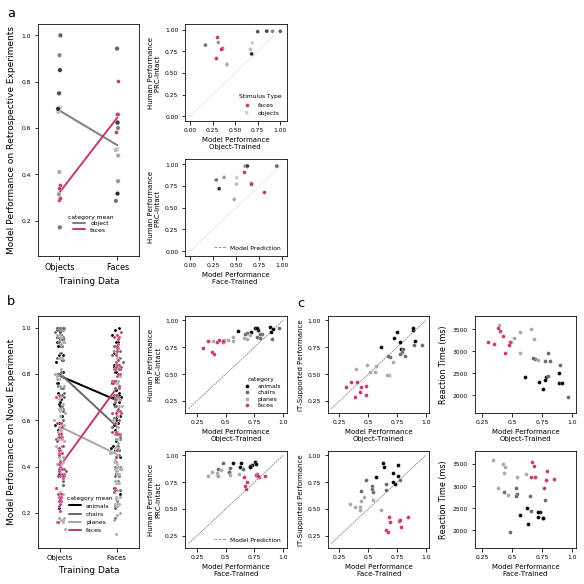

In [336]:
face_color = '#c53a73'
PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':6, 
          'legend_fontsize':6, 's':15, 'xtick_size':6, 'ylabel_fontsize':7, 'xlabel_fontsize':7, 'labelpad':2}

label_size = 13
label_height = 1.05
label_dist = -.30

fig = plt.figure(constrained_layout=True, figsize=[8, 8])
gs = fig.add_gridspec(4, 4, wspace=0, hspace=1) 

###
ax = fig.add_subplot(gs[0:2, 0:1]); 
face_retrospective_models(PARAMS)
plt.text(label_dist, label_height-.02, 'a', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:1, 1:2]); 
face_retrospective_human(ax, PARAMS, 'prc_intact', 'fc6')
#plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[1:2, 1:2]); 
face_retrospective_human(ax, PARAMS, 'prc_intact', 'vggface', show_legend=0)
#plt.text(label_dist, label_height, 'c', fontsize=label_size, transform=ax.transAxes,)

###
ax = fig.add_subplot(gs[2:4, 0:1]);
face_novel_model(PARAMS)
plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[2:3, 1:2]); 
face_novel_human('imagenet', 'human', PARAMS, legend=1)
#plt.text(label_dist, label_height, 'e', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 1:2]); 
face_novel_human('vggface', 'human', PARAMS, legend=0)
#plt.text(label_dist, label_height, 'f', fontsize=label_size, transform=ax.transAxes,)

# ###
ax = fig.add_subplot(gs[2:3, 2:3]); 
face_novel_human('imagenet', 'it', PARAMS)
plt.text(label_dist, label_height+.05, 'c', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 2:3]); 
face_novel_human('vggface', 'it', PARAMS)
#plt.text(label_dist, label_height, 'h', fontsize=label_size, transform=ax.transAxes,)

ax = fig.add_subplot(gs[2:3, 3:4]); 
face_novel_human('imagenet', 'rt', PARAMS)
#plt.text(label_dist, label_height, 'i', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 3:4]); 
face_novel_human('vggface', 'rt', PARAMS)
#plt.text(label_dist, label_height, 'j', fontsize=label_size, transform=ax.transAxes,)

plt.savefig(os.path.join(_location, 'training_effects_square.pdf'), format='pdf', bbox_inches = "tight")

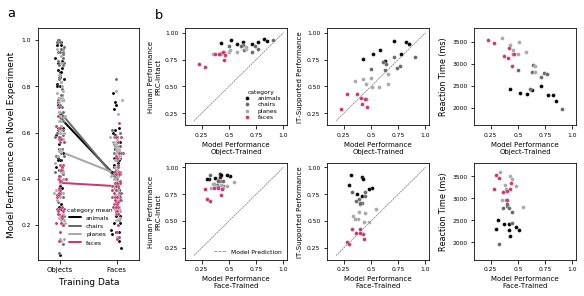

In [337]:

#face_novel_human('imagenet', 'human', PARAMS, view_type='original', legend=1)
face_color = '#c53a73'
PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':6, 
          'legend_fontsize':6, 's':15, 'xtick_size':6, 'ylabel_fontsize':7, 'xlabel_fontsize':7, 'labelpad':2}

label_size = 13
label_height = 1.05
label_dist = -.30

fig = plt.figure(constrained_layout=True, figsize=[8, 4])
gs = fig.add_gridspec(2, 4, wspace=0, hspace=1) 

ax = fig.add_subplot(gs[0:2, 0:1]);
face_novel_model(PARAMS, view_type='original')
plt.text(label_dist, label_height, 'a', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:1, 1:2]); 
face_novel_human('imagenet', 'human', PARAMS, legend=1, view_type='original')
plt.text(label_dist, label_height+.05, 'b', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[1:2, 1:2]); 
face_novel_human('vggface', 'human', PARAMS, legend=0, view_type='original')

# ###
ax = fig.add_subplot(gs[0:1, 2:3]); 
face_novel_human('imagenet', 'it', PARAMS, view_type='original')
ax = fig.add_subplot(gs[1:2, 2:3]); 
face_novel_human('vggface', 'it', PARAMS, view_type='original')

ax = fig.add_subplot(gs[0:1, 3:4]); 
face_novel_human('imagenet', 'rt', PARAMS, view_type='original')
ax = fig.add_subplot(gs[1:2, 3:4]); 
face_novel_human('vggface', 'rt', PARAMS, view_type='original')
plt.savefig(os.path.join(_location, 'training_effects_unfoveated.pdf'), format='pdf', bbox_inches = "tight")